# An example for node classification with CORA dataset

In [1]:
from sten.embedding import (
    GraphCSR, Systems, SysLeft, SystemRight, Multiplied, Reciprocals, SumConnections
)
from matplotlib.pyplot import figure
import networkx as net
import numpy as np
import sklearn
from sklearn.cluster import KMeans
import community
from stellargraph import datasets

from IPython.display import display, HTML

np.random.seed(19680801)


In [2]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load(largest_connected_component_only=True)

In [3]:
node_remapping = {n: i for i, n in enumerate(G.nodes())}

In [4]:
node2subject = {new_node: node_subjects[old_node] for old_node, new_node in node_remapping.items()}
subject2int = {subject: i for i, subject in enumerate(set(node2subject.values()))}
node2subject = np.array([subject2int[node2subject[i]] for i in range(len(node2subject))], dtype=np.int32)

In [5]:
g = net.MultiGraph()
g.add_edges_from(((node_remapping[u], node_remapping[v]) for u, v in G.edges()))
print(g.number_of_nodes())

2485


In [6]:
embeddings = Systems(
    system=SysLeft(GraphCSR(g), 0.7),
    make_system_right=lambda n: SystemRight(GraphCSR(g), n),
    n_nodes=g.number_of_nodes(),
).results().T

# normalize values
for i in range(embeddings.shape[1]):
    embeddings[:, i] /= embeddings[:, i].max()

# 7 -- number of the ground-turth clusters
kmeans = KMeans(n_clusters=7)
clustering = kmeans.fit(embeddings).labels_

/home/vhhlu/programs/miniconda3/envs/sne01/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [7]:
# Normalized mutual information (NMI) score
# for the generated clustering and the ground-truth communities

print("NMI score with ground truth: ", sklearn.metrics.normalized_mutual_info_score(node2subject, clustering))

NMI score with ground truth:  0.1793065083038241


In [8]:
# Comparison with python-louvain best_partition communities
best_partition = community.best_partition(g)
bp = np.array([best_partition[i] for i in range(len(best_partition))])
print("NMI score between louvain best partition and the ground truth", sklearn.metrics.normalized_mutual_info_score(bp, node2subject))

NMI score between louvain best partition and the ground truth 0.45583531843005853


In [9]:
# Aplying PCA dimensionality reduction to make possible 3d plotting
# of the generated embeddings

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(embeddings)
embeddings_ld = pca.transform(embeddings)
embeddings_ld.shape
# 7 -- number of the ground-turth clusters
kmeans_ld = KMeans(n_clusters=7)
clustering_ld = kmeans_ld.fit(embeddings_ld).labels_

In [10]:
print("NMI score with ground truth (PCA applied, 3 dimensions): ", sklearn.metrics.normalized_mutual_info_score(node2subject, clustering))
print(sklearn.metrics.normalized_mutual_info_score(clustering_ld, node2subject))

NMI score with ground truth (PCA applied, 3 dimensions):  0.1793065083038241
0.3351317392391934


In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(embeddings)

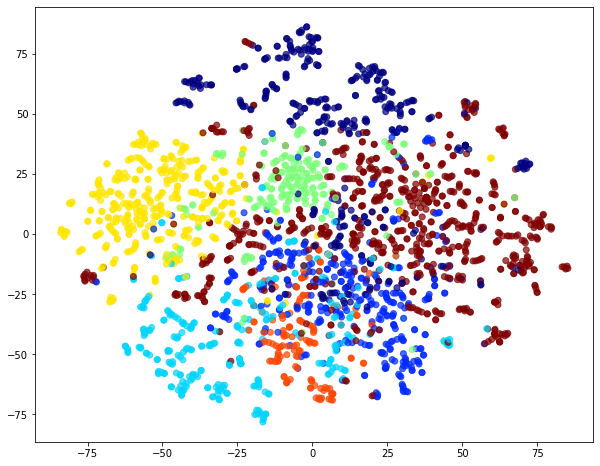

In [12]:
plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node2subject,
    cmap="jet",
    alpha=0.7,
)